In [ ]:
import os
import time
import random
import numpy as np
import nibabel as nib
#import tensorflow as tf
#from network import build_FCN
from image_utils import tf_categorical_accuracy, tf_categorical_dice
from image_utils import crop_image, rescale_intensity, data_augmenter,crop_image_bymask
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import cv2

In [ ]:
def get_random_batch(filename_list, batch_size, image_size=192, data_augmentation=False,
                     shift=0.0, rotate=0.0, scale=0.0, intensity=0.0, flip=False):
    # Randomly select batch_size images from filename_list
    n_file = len(filename_list)
    n_selected = 0
    images = []
    labels = []
    while n_selected < n_file:
        #rand_index = random.randrange(n_file)
        rand_index = n_selected
        image_name, label_name = filename_list[rand_index]
        if os.path.exists(image_name) and os.path.exists(label_name):
            print('  Select {0} {1}'.format(image_name, label_name))

            # Read image and label
            image = nib.load(image_name).get_data()
            label = nib.load(label_name).get_data()

            # Handle exceptions
            if image.shape != label.shape:
                print('Error: mismatched size, image.shape = {0}, '
                      'label.shape = {1}'.format(image.shape, label.shape))
                print('Skip {0}, {1}'.format(image_name, label_name))
                continue

            if image.max() < 1e-6:
                print('Error: blank image, image.max = {0}'.format(image.max()))
                print('Skip {0} {1}'.format(image_name, label_name))
                continue

            # Normalise the image size
            X, Y, Z = image.shape
            cx, cy = int(X / 2), int(Y / 2)
            #image = crop_image_bymask_(image, label,cx,cy ,image_size)
            #label = crop_image_bymask_(label, label,cx,cy ,image_size)
            #print(image.shape, label.shape)
            #image = crop_image(image, cx, cy, image_size)
            #label = crop_image(label, cx, cy, image_size)
            #image = np.array(image)
            #label = np.array(label)
            # Intensity rescaling
            image = rescale_intensity(image, (1.0, 99.0))
            #print(image.shape, label.shape)
            # Append the image slices to the batch
            # Use list for appending, which is much faster than numpy array
            for z in range(Z):
                img  = image[:,:,z]
                lbl  = label[:,:,z]
                img = np.array(cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_CUBIC))
                lbl = np.array(cv2.resize(lbl, (image_size, image_size), interpolation=cv2.INTER_CUBIC))
                #image = np.expand_dims(image, axis=2)
                #label = np.expand_dims(label, axis=2)
                images += [img]
                labels += [lbl]

            # Increase the counter
            n_selected += 1

    # Convert to a numpy array
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    # Add the channel dimension
    # tensorflow by default assumes NHWC format
    print(images.shape, labels.shape)
    images = np.expand_dims(images, axis=3)
    #labels = np.expand_dims(labels, axis=3)
    # Perform data augmentation
    if data_augmentation:
        aug_images, aug_labels = data_augmenter(images, labels,
                                        shift=shift, rotate=rotate,
                                        scale=scale,
                                        intensity=intensity, flip=flip)
        images = np.concatenate((images, aug_images),axis =0 )
        labels = np.concatenate((labels, aug_labels),axis = 0)
            
    return images, labels


In [ ]:

IMG_DIR = "/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases"
LABEL_DIR = "/content/drive/My Drive/covid/mask"
img_list = os.listdir(IMG_DIR)
label_list = os.listdir(LABEL_DIR)

img_list.remove('ReadMe.txt')
img_list.sort() , label_list.sort()
#print(img_list,label_list )
hsvmr_filename_pairs = [(os.path.join(IMG_DIR,x),os.path.join(LABEL_DIR,y)) for x,y in zip(img_list,label_list)]
print(hsvmr_filename_pairs)
train_data_list = hsvmr_filename_pairs[:8]
train_data_list.extend(hsvmr_filename_pairs[10:17])
val_data_list = hsvmr_filename_pairs[8:10]
val_data_list.extend(hsvmr_filename_pairs[17:])
print(len(train_data_list) , len(val_data_list))

[('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_001.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_001.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_002.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_002.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_003.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_003.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_004.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_004.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_005.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_005.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_006.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_006.nii.gz'), ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_007.nii.gz', '/content/drive/My Drive/covid/mask/coronacases_007.nii.gz')

In [ ]:
train_data_list

[('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_001.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_001.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_002.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_002.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_003.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_003.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_004.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_004.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_005.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_005.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_006.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_006.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_007.nii.gz',
  '/content/drive/My Drive/covid/mask/coro

In [ ]:
val_data_list

[('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_009.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_009.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_010.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_010.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_40_86625_0.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_40_86625_0.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_4_85506_1.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_4_85506_1.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_7_85703_0.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_7_85703_0.nii.gz')]

In [ ]:
image_size = 192
train_batch_size = 10
images, labels = get_random_batch(train_data_list,
                                              train_batch_size,
                                              image_size=image_size,
                                              data_augmentation=True,
                                              shift=0, rotate=10, scale=0.2,
                                              intensity=0, flip=True)




  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_001.nii.gz /content/drive/My Drive/covid/mask/coronacases_001.nii.gz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_002.nii.gz /content/drive/My Drive/covid/mask/coronacases_002.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_003.nii.gz /content/drive/My Drive/covid/mask/coronacases_003.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_004.nii.gz /content/drive/My Drive/covid/mask/coronacases_004.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_005.nii.gz /content/drive/My Drive/covid/mask/coronacases_005.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_006.nii.gz /content/drive/My Drive/covid/mask/coronacases_006.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_007.nii.gz /content/drive/My Drive/covid/mask/coronacases_007.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_008.nii.gz /content/drive/My Drive/covid/mask/coronacases_008

In [ ]:
labels = np.expand_dims(labels, axis=3)
print(images.shape, labels.shape)

(5572, 192, 192, 1) (5572, 192, 192, 1)


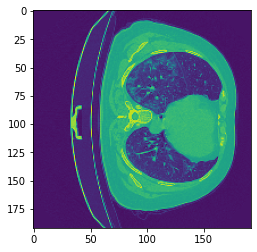

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 125

img = np.squeeze(images[n],2)
plt.imshow(img)

1296


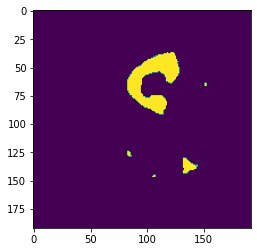

In [ ]:


lbl = np.squeeze(labels[n],2)
print(np.sum(lbl == 1))
plt.imshow(lbl)

In [ ]:
!pip install segmentation_models

In [ ]:
#Import libraries
import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet , PSPNet
from segmentation_models.backbones.backbones_factory import Backbones
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import tensorflow
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

In [ ]:
from sklearn.model_selection import train_test_split
X = images
y = labels
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2000)

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = Backbones.get_preprocessing(BACKBONE)
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)
print(x_train.shape, x_val.shape)
n_classes = 1
#Build your model 

N = x_train.shape[-1]

base_model = Unet(backbone_name=BACKBONE ,encoder_weights= None , input_shape=(None, None, N) ,classes=n_classes)
#base_model = PSPNet(input_shape=(192, 192, N) ,classes=n_classes)
#inp = Input(shape=(192, 192, N))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)
#l2 = Conv2D(1, (1, 1))(out)
#model = Model(inp, n_classes, name=base_model.name)
model = base_model
model.summary()

(4179, 192, 192, 1) (1393, 192, 192, 1)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_34[0][0]          
____________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
LR = 0.0001
#optim = keras.optimizers.Adam(LR)
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return (numerator )  / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())


# compile model
#model.compile('Adam', loss=loss, metrics=[dice_coefficient])
model.compile('Adam', loss=loss, metrics=[dice_coefficient])

In [ ]:

# load best weights
model.load_weights('covid_model.h5')

In [ ]:

# fit model
model.fit(x=x_train,y=y_train,batch_size=16,epochs=20, validation_data=(x_val, y_valid),)


Train on 4179 samples, validate on 1393 samples
Epoch 1/20
4179/4179 [==============================] - 105s 25ms/sample - loss: 0.1644 - dice_coefficient: 0.8584 - val_loss: 0.1822 - val_dice_coefficient: 0.8416
Epoch 2/20
4179/4179 [==============================] - 102s 24ms/sample - loss: 0.1607 - dice_coefficient: 0.8610 - val_loss: 0.1765 - val_dice_coefficient: 0.8467
Epoch 3/20
4179/4179 [==============================] - 102s 24ms/sample - loss: 0.1521 - dice_coefficient: 0.8679 - val_loss: 0.1683 - val_dice_coefficient: 0.8513
Epoch 4/20
4179/4179 [==============================] - 102s 25ms/sample - loss: 0.1478 - dice_coefficient: 0.8712 - val_loss: 0.1695 - val_dice_coefficient: 0.8505
Epoch 5/20
4179/4179 [==============================] - 102s 25ms/sample - loss: 0.1420 - dice_coefficient: 0.8760 - val_loss: 0.1597 - val_dice_coefficient: 0.8621
Epoch 6/20
4179/4179 [==============================] - 102s 24ms/sample - loss: 0.1418 - dice_coefficient: 0.8761 - val_loss: 

In [ ]:
 import numpy as np
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("covid_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("covid_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:

# load best weights
#model.load_weights('myo_model1.h5')

In [ ]:
model.evaluate(x_train, y_train, verbose=1)

[0.11235430572457392, 0.9005492]

In [ ]:

model.evaluate(x_val, y_valid, verbose=1)


[0.1635912865806807, 0.8599011]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)


In [ ]:
counter = 0
for i in range(y_valid.shape[0]):
  if np.sum(y_valid[i] ==1) > 0:
    counter+=1
print(counter)

720


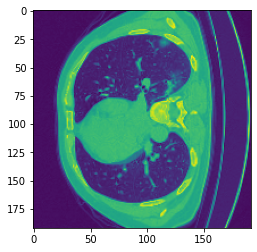

In [ ]:
import matplotlib.pyplot as plt
n =1350
plt.imshow(np.squeeze(x_val[n], 2))


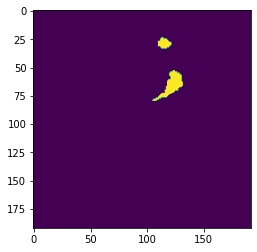

In [ ]:
plt.imshow((np.squeeze(y_valid[n],2)))

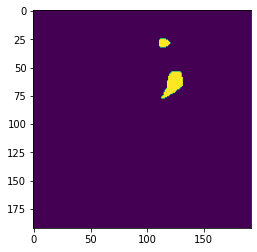

In [ ]:
plt.imshow(np.round(np.squeeze(preds_val[n],2)))

In [ ]:
dices = []
for i in range(preds_val.shape[0]):
    pred = np.round(preds_val[i])
    gt = y_valid[i]
    dice = (np.sum(pred[gt==1])*2.0 +0.0001) / ((np.sum(pred) + np.sum(gt)) +0.0001)
    dices.append(dice)        
        
print("Validation Dice Score:" ,np.mean(dices))     

Validation Dice Score: 0.8638590648575297


## Test Data


In [ ]:
val_data_list1 = val_data_list[:]
val_data_list1

[('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_009.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_009.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_010.nii.gz',
  '/content/drive/My Drive/covid/mask/coronacases_010.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_40_86625_0.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_40_86625_0.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_4_85506_1.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_4_85506_1.nii.gz'),
 ('/content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_7_85703_0.nii.gz',
  '/content/drive/My Drive/covid/mask/radiopaedia_7_85703_0.nii.gz')]

In [ ]:
image_size = 192
train_batch_size = 21
Test_images, Test_labels = get_random_batch(val_data_list1,
                                              train_batch_size,
                                              image_size=image_size,
                                              data_augmentation=False,
                                              shift=0, rotate=10, scale=0.2,
                                              intensity=0, flip=False)


  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_009.nii.gz /content/drive/My Drive/covid/mask/coronacases_009.nii.gz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/coronacases_010.nii.gz /content/drive/My Drive/covid/mask/coronacases_010.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_40_86625_0.nii.gz /content/drive/My Drive/covid/mask/radiopaedia_40_86625_0.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_4_85506_1.nii.gz /content/drive/My Drive/covid/mask/radiopaedia_4_85506_1.nii.gz
  Select /content/drive/My Drive/covid/COVID-19-CT-Seg_20cases/radiopaedia_7_85703_0.nii.gz /content/drive/My Drive/covid/mask/radiopaedia_7_85703_0.nii.gz
(734, 192, 192) (734, 192, 192)


In [ ]:
Test_images1, Test_labels1 = Test_images[:], Test_labels[:]
Test_labels1 = np.expand_dims(Test_labels1, axis=3)
print(Test_images1.shape, Test_labels1.shape)
X_test = Test_images1
y_test = Test_labels1
X_test = preprocess_input(X_test)
#y_test = preprocess_input(y_test)

(734, 192, 192, 1) (734, 192, 192, 1)


In [ ]:
model.evaluate(X_test, y_test, verbose=1)

[3.551482279229229, 0.55640405]

In [ ]:
preds_test = model.predict(X_test, verbose=1)

In [ ]:
dices = []
for i in range(preds_test.shape[0]):
    pred = np.round(preds_test[i])
    gt = y_test[i]
    dice = (np.sum(pred[gt==1])*2.0 +0.00001) / ((np.sum(pred) + np.sum(gt)) +0.00001)
    dices.append(dice)        
        
print("Test Dice Score:" ,np.mean(dices))     

Test Dice Score: 0.791006080096697


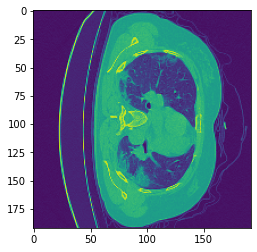

In [ ]:
n = 439
plt.imshow(np.squeeze(X_test[n], 2))

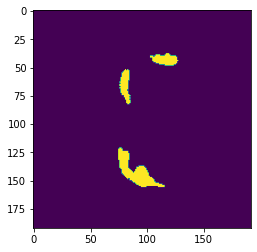

In [ ]:
plt.imshow(np.squeeze(y_test[n], 2))

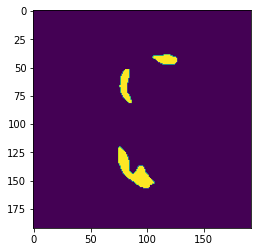

In [ ]:
plt.imshow(np.round(np.squeeze(preds_test[n], 2)))